In [1]:
import numpy as np
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt

In [1]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


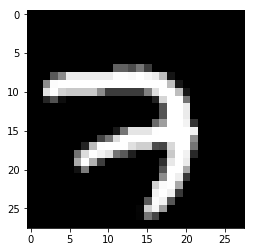

[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]


In [3]:
plt.gray()
plt.imshow(mnist.train.images[0].reshape(28, 28))
plt.show()
print(mnist.train.labels[0])

In [4]:
def create_batch(X, Y, batch_size):
    m = X.shape[-1]
    n_batch = int(m / batch_size)

    X_batches = []
    Y_batches = []

    permutation = np.random.permutation(m)
    X_shuffle = X[:, permutation]
    Y_shuffle = Y[:, permutation]

    for i in range(n_batch):
        X_batch = X_shuffle[:, i * batch_size: (i+1) * batch_size]
        Y_batch = Y_shuffle[:, i * batch_size: (i+1) * batch_size]
        X_batches.append(X_batch)
        Y_batches.append(Y_batch)

    if m % n_batch != 0:
        X_batch = X_shuffle[:, n_batch * batch_size:]
        Y_batch = Y_shuffle[:, n_batch * batch_size:]
        X_batches.append(X_batch)
        Y_batches.append(Y_batch)
        n_batch += 1

    return X_batches, Y_batches, n_batch

def plot_cost(cost):
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111)
    tc_plt, = ax1.plot(cost, label='Cost Graph')
    ax1.legend(handles=[tc_plt])
    plt.show()

In [9]:
with tf.device('/device:GPU:0'):
    x = tf.placeholder(tf.float32, shape=[None, 784], name='x')
    y = tf.placeholder(tf.float32, shape=[None, 10], name='y')
    
    a1 = tf.contrib.layers.fully_connected(x, 300, weights_initializer=tf.contrib.layers.xavier_initializer(),\
                                       biases_initializer=tf.zeros_initializer(), weights_regularizer=tf.contrib.layers.l2_regularizer(0.01))

    a2 = tf.contrib.layers.fully_connected(a1, 100, weights_initializer=tf.contrib.layers.xavier_initializer(),\
                                           biases_initializer=tf.zeros_initializer(), weights_regularizer=tf.contrib.layers.l2_regularizer(0.01))

    o = tf.contrib.layers.fully_connected(a2, 10, activation_fn=tf.nn.sigmoid, weights_initializer=tf.contrib.layers.xavier_initializer(),\
                                           biases_initializer=tf.zeros_initializer(), weights_regularizer=tf.contrib.layers.l2_regularizer(0.01))

    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=o))
    optimizer = tf.train.AdamOptimizer().minimize(cost)

    correct_prediction = tf.equal(tf.argmax(o, axis=1), tf.argmax(y, axis=1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

3 fully connected layers
test accuracy: 0.9722


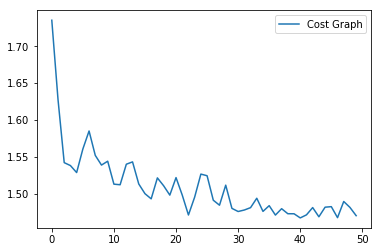

In [10]:
epoch = 50
cost_cache = []
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(epoch):
        X_batches, Y_batches, n_batch = create_batch(train_images.T, mnist.train.labels.T, batch_size=128)
        
        for j in range(n_batch):
            _, batch_cost = sess.run([optimizer, cost], feed_dict = {x:X_batches[j].T, y:Y_batches[j].T})
            
        cost_cache.append(batch_cost)
    
    print('3 fully connected layers')
    #print('train accuracy:', accuracy.eval(feed_dict={x:mnist.train.images, y:mnist.train.labels}))
    print('test accuracy:', accuracy.eval(feed_dict={x:test_images, y:mnist.test.labels}))
    plot_cost(cost_cache)

In [11]:
with tf.device('/device:GPU:0'):
    x = tf.placeholder(tf.float32, shape=[None, 784], name='x')
    y = tf.placeholder(tf.float32, shape=[None, 10], name='y')
    
    a1 = tf.contrib.layers.fully_connected(x, 300, weights_initializer=tf.contrib.layers.xavier_initializer(),\
                                       biases_initializer=tf.zeros_initializer(), weights_regularizer=tf.contrib.layers.l2_regularizer(0.01))
    bn1 = tf.contrib.layers.batch_norm(a1)

    a2 = tf.contrib.layers.fully_connected(bn1, 100, weights_initializer=tf.contrib.layers.xavier_initializer(),\
                                           biases_initializer=tf.zeros_initializer(), weights_regularizer=tf.contrib.layers.l2_regularizer(0.01))
    bn2 = tf.contrib.layers.batch_norm(a2)

    o = tf.contrib.layers.fully_connected(bn2, 10, activation_fn=tf.nn.sigmoid, weights_initializer=tf.contrib.layers.xavier_initializer(),\
                                           biases_initializer=tf.zeros_initializer(), weights_regularizer=tf.contrib.layers.l2_regularizer(0.01))

    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=o))
    optimizer = tf.train.AdamOptimizer().minimize(cost)

    correct_prediction = tf.equal(tf.argmax(o, axis=1), tf.argmax(y, axis=1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

3 fully connected layers with batch norm
test accuracy: 0.9822


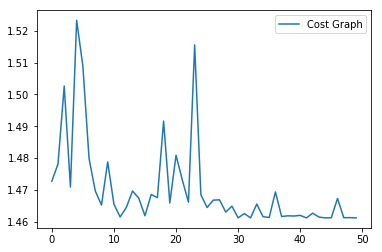

In [12]:
epoch = 50
cost_cache = []
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(epoch):
        X_batches, Y_batches, n_batch = create_batch(mnist.train.images.T, mnist.train.labels.T, batch_size=64)
        
        for j in range(n_batch):
            _, batch_cost = sess.run([optimizer, cost], feed_dict = {x:X_batches[j].T, y:Y_batches[j].T})
        cost_cache.append(batch_cost)
    
    print('3 fully connected layers with batch norm')
    #print('train accuracy:', accuracy.eval(feed_dict={x:mnist.train.images, y:mnist.train.labels}))
    print('test accuracy:', accuracy.eval(feed_dict={x:mnist.test.images, y:mnist.test.labels}))
    plot_cost(cost_cache)

### How and why batch normalization helped.
In my experiment, I implement 3 fully connected layers neural network. I add batch norm after each layer, except the last softmax layer. The result shows that batch norm helps to increase accuracy by 1 percent(97.22% w/o BN vs 98.22% with BN).
Batch normalization set every hidden layer value to mean zero and variance one. Batch norm helps the network do better on dealing with 'coveriate shift', reducing the amount of value shifting. In addition, it helps to prevent weights grows extremely large in later layers. It also have slightly regularization effect because it add noise to each hidden layer's activision value.

In [13]:
with tf.device('/device:GPU:0'):
    x = tf.placeholder(tf.float32, shape=[None, 784], name='x')
    y = tf.placeholder(tf.float32, shape=[None, 10], name='y')
    
    x_image = tf.reshape(x, [-1, 28, 28, 1])
    
    w_conv1 = tf.get_variable('w_conv1', shape=[3,3,1,16], initializer=tf.contrib.layers.xavier_initializer())
    b_conv1 = tf.get_variable('b_conv1', shape=[16], initializer=tf.zeros_initializer())
    
    w_conv2 = tf.get_variable('w_conv2', shape=[3,3,16,32], initializer=tf.contrib.layers.xavier_initializer())
    b_conv2 = tf.get_variable('b_conv2', shape=[32], initializer=tf.zeros_initializer())
    
    w_fc1 = tf.get_variable('w_fc1', shape=[6*6*32, 512], initializer=tf.contrib.layers.xavier_initializer())
    b_fc1 = tf.get_variable('b_fc1', shape=[512], initializer=tf.zeros_initializer())
    
    w_fc2 = tf.get_variable('w_fc2', shape=[512, 10], initializer=tf.contrib.layers.xavier_initializer())
    b_fc2 = tf.get_variable('b_fc2', shape=[10], initializer=tf.zeros_initializer())
    
    
    h_conv1 = tf.nn.relu(tf.nn.conv2d(x_image, w_conv1, strides=[1, 1, 1, 1], padding='SAME') + b_conv1)
    h_pool1 = tf.nn.max_pool(h_conv1, ksize=[1,3,3,1], strides=[1,2,2,1], padding='VALID')
    
    h_conv2 = tf.nn.relu(tf.nn.conv2d(h_pool1, w_conv2, strides=[1, 1, 1, 1], padding='SAME') + b_conv2)
    h_pool2 = tf.nn.max_pool(h_conv2, ksize=[1,3,3,1], strides=[1,2,2,1], padding='VALID')
    
    h_pool2_flat = tf.reshape(h_pool2, [-1, 6*6*32])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, w_fc1) + b_fc1)
    
    y_conv = tf.matmul(h_fc1, w_fc2) + b_fc2
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=y_conv))
    optimizer = tf.train.AdamOptimizer().minimize(cost)
    
    correct_prediction = tf.equal(tf.argmax(y_conv, axis=1), tf.argmax(y, axis=1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


CNN: 2 conv layers 1 fully connected layers
test accuracy: 0.9929


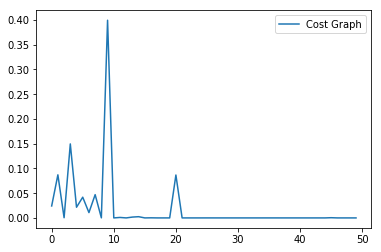

In [15]:
epoch = 50
cost_cache = []
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(epoch):
        X_batches, Y_batches, n_batch = create_batch(mnist.train.images.T, mnist.train.labels.T, batch_size=64)
        
        for j in range(n_batch):
            _, batch_cost = sess.run([optimizer, cost], feed_dict = {x:X_batches[j].T, y:Y_batches[j].T})
            
        cost_cache.append(batch_cost)
    
    print('CNN: 2 conv layers 1 fully connected layers')
    print('test accuracy:', accuracy.eval(feed_dict={x:mnist.test.images, y:mnist.test.labels}))
    plot_cost(cost_cache)

In [17]:
with tf.device('/device:GPU:0'):
    x = tf.placeholder(tf.float32, shape=[None, 784], name='x')
    y = tf.placeholder(tf.float32, shape=[None, 10], name='y')
    
    x_image = tf.reshape(x, [-1, 28, 28, 1])
    
    
    h_conv1 = tf.nn.relu(tf.nn.conv2d(x_image, w_conv1, strides=[1, 1, 1, 1], padding='SAME') + b_conv1)
    h_pool1 = tf.nn.max_pool(h_conv1, ksize=[1,3,3,1], strides=[1,2,2,1], padding='VALID')
    
    bn1 = tf.contrib.layers.batch_norm(h_pool1)
    
    h_conv2 = tf.nn.relu(tf.nn.conv2d(bn1, w_conv2, strides=[1, 1, 1, 1], padding='SAME') + b_conv2)
    h_pool2 = tf.nn.max_pool(h_conv2, ksize=[1,3,3,1], strides=[1,2,2,1], padding='VALID')
    
    bn2 = tf.contrib.layers.batch_norm(h_pool2)
    
    h_pool2_flat = tf.reshape(bn2, [-1, 6*6*32])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, w_fc1) + b_fc1)
    
    y_conv = tf.matmul(h_fc1, w_fc2) + b_fc2
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=y_conv))
    optimizer = tf.train.AdamOptimizer().minimize(cost)
    
    correct_prediction = tf.equal(tf.argmax(y_conv, axis=1), tf.argmax(y, axis=1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

CNN: 2 conv layers 1 fully connected layers with batch norm
test accuracy: 0.9925


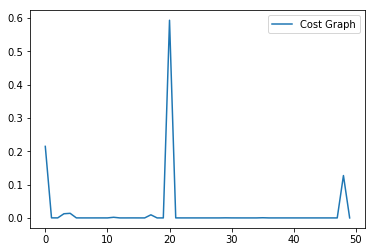

In [19]:
epoch = 50
cost_cache = []
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(epoch):
        X_batches, Y_batches, n_batch = create_batch(mnist.train.images.T, mnist.train.labels.T, batch_size=64)
        
        for j in range(n_batch):
            _, batch_cost = sess.run([optimizer, cost], feed_dict = {x:X_batches[j].T, y:Y_batches[j].T})
            
        cost_cache.append(batch_cost)
    
    print('CNN: 2 conv layers 1 fully connected layers with batch norm')
    print('test accuracy:', accuracy.eval(feed_dict={x:mnist.test.images, y:mnist.test.labels}))
    plot_cost(cost_cache)

### How and why batch normalization helped.
In my experiment, I implement CNN with 2 conv layers and 1 fully connnected layer. I add batch norm layer after each conv layer. However, my result shows that batch norm doesn't really help(99.29% w/o BN vs 99.25% with BN). Possible explanation is that, the benefits of batch norm is not significant in shallow neural networks, it usually works better in deep neural networks. Also, even without batch norm, the accuracy has been so high(99.29%), batch norm layers actually add noise and make the prediction slightly worst.

Theoretically, Batch normalization set every hidden layer value to mean zero and variance one. Batch norm helps the network do better on dealing with 'coveriate shift', reducing the amount of value shifting. In addition, it helps to prevent weights grows extremely large in later layers. It also have slightly regularization effect because, it add noise to each hidden layer's activision value.